# P03_01_ARIMA_AR

In [1]:
section_fig_main_title = 'P03_01_ARIMA_AR'

In [2]:
import tensorflow as tf
tf.__version__

'2.6.0'

In [3]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
%config InlineBackend.figure_format = 'retina'


In [5]:
import gif

In [6]:
import sys
# print(sys.executable)

In [7]:
# !/Users/amin/Desktop/proj/env/bin/python -m pip install matplotlib

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns

In [10]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
# import statsmodels.api as sm

## Read data

In [11]:
csv_path = "../Data/jena_climate_2009_2016.csv"
df = pd.read_csv(csv_path, index_col=0, parse_dates=True)

In [12]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [13]:
df.columns

Index(['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)',
       'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 420551 entries, 2009-01-01 00:10:00 to 2017-01-01 00:00:00
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   p (mbar)         420551 non-null  float64
 1   T (degC)         420551 non-null  float64
 2   Tpot (K)         420551 non-null  float64
 3   Tdew (degC)      420551 non-null  float64
 4   rh (%)           420551 non-null  float64
 5   VPmax (mbar)     420551 non-null  float64
 6   VPact (mbar)     420551 non-null  float64
 7   VPdef (mbar)     420551 non-null  float64
 8   sh (g/kg)        420551 non-null  float64
 9   H2OC (mmol/mol)  420551 non-null  float64
 10  rho (g/m**3)     420551 non-null  float64
 11  wv (m/s)         420551 non-null  float64
 12  max. wv (m/s)    420551 non-null  float64
 13  wd (deg)         420551 non-null  float64
dtypes: float64(14)
memory usage: 48.1 MB


In [15]:
# df.corr().T

I choose the first 20000 timestamps as sub-data and used 720 as lag. The model checks out the 720 timestamps and uses them for future predictions. (this selection is based on keras website example for time series modeling). later I apply the model for 72 timestamps prediction ahead (12 hours ahead).

In [16]:
column_name = 'T (degC)'
start = 0
end = 20000

training_df = df[column_name][start:end]

## TO BE stationary OR NOT TO BE stationary

Let's use Augmented Dickey Fuller test (ADF Test) to see if data is stationary or not.

In [17]:
from statsmodels.tsa.stattools import adfuller

In [18]:
adfuller_test = adfuller(df[column_name][start: end], autolag='AIC')

In [19]:
test_details = ['ADF', 'P-Vale', 'NumofLags', 'NumOfObser_ADF_regr', 'critical_values']
for i,name in enumerate(test_details):
    print(name, '  ', adfuller_test[i])

ADF    -5.948488286558909
P-Vale    2.175401053698951e-07
NumofLags    45
NumOfObser_ADF_regr    19954
critical_values    {'1%': -3.430677760921837, '5%': -2.861684858789646, '10%': -2.56684710437876}


Base on ADF test, the Data is stationary (p-value < 0.05) so null hypothesis (data is not stationary) is rejected. also as was observed in EDA parts, no trend is observed. 

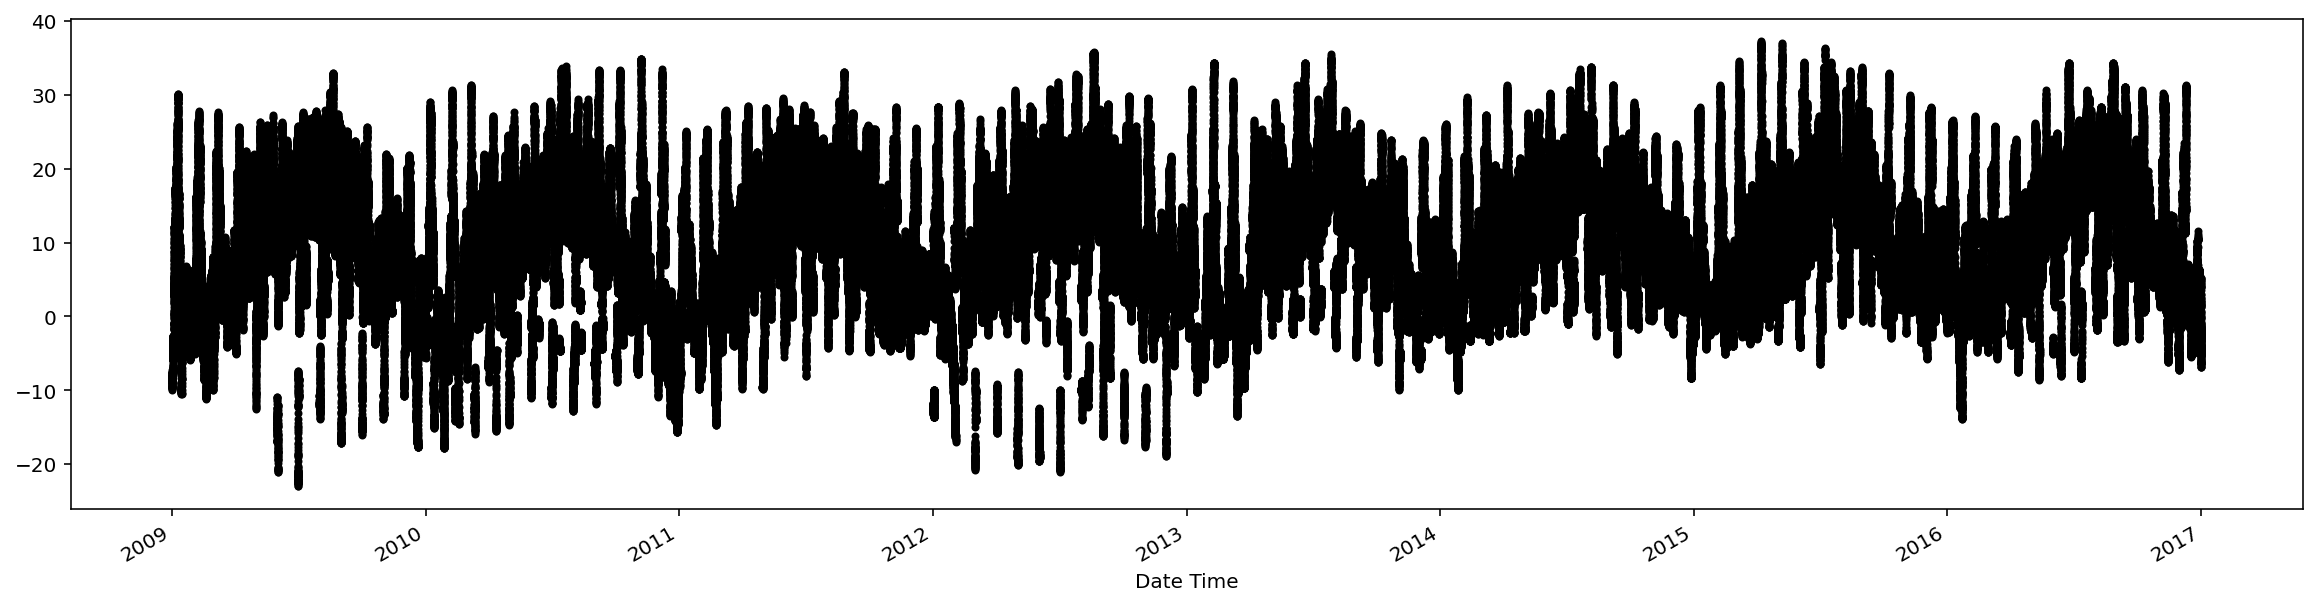

In [34]:
plt.figure(figsize=(20,5))
df['T (degC)'].plot(style='k.')
plt.show()

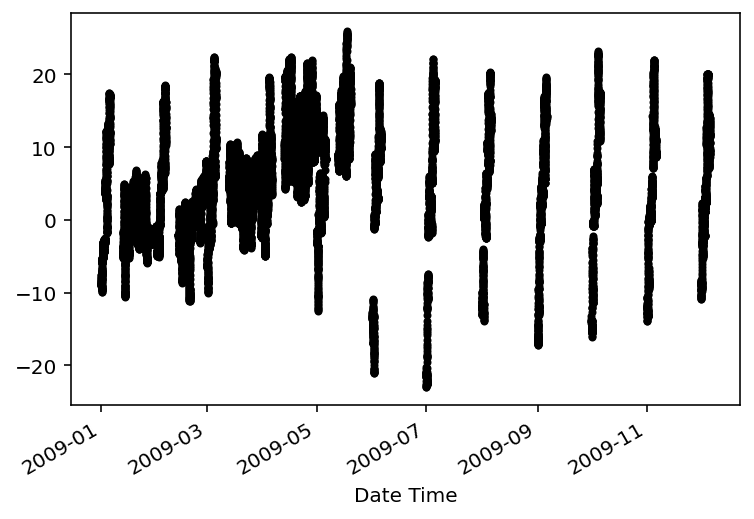

In [36]:
# plt.figure(figsize=(20,5))
training_df.plot(style='k.')
plt.show()

However I see a seanality in data! Let's split the data and check out the mean and variance and compare if there are any changes.

In [37]:
# source https://machinelearningmastery.com/time-series-data-stationary-python/
X = df['T (degC)']

split = int(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=8.825443, mean2=10.074849
variance1=76.913139, variance2=64.212880


The mean and variance are so close! let's plot the histogram for data and check out the data distribution.

array([[<AxesSubplot:title={'center':'T (degC)'}>]], dtype=object)

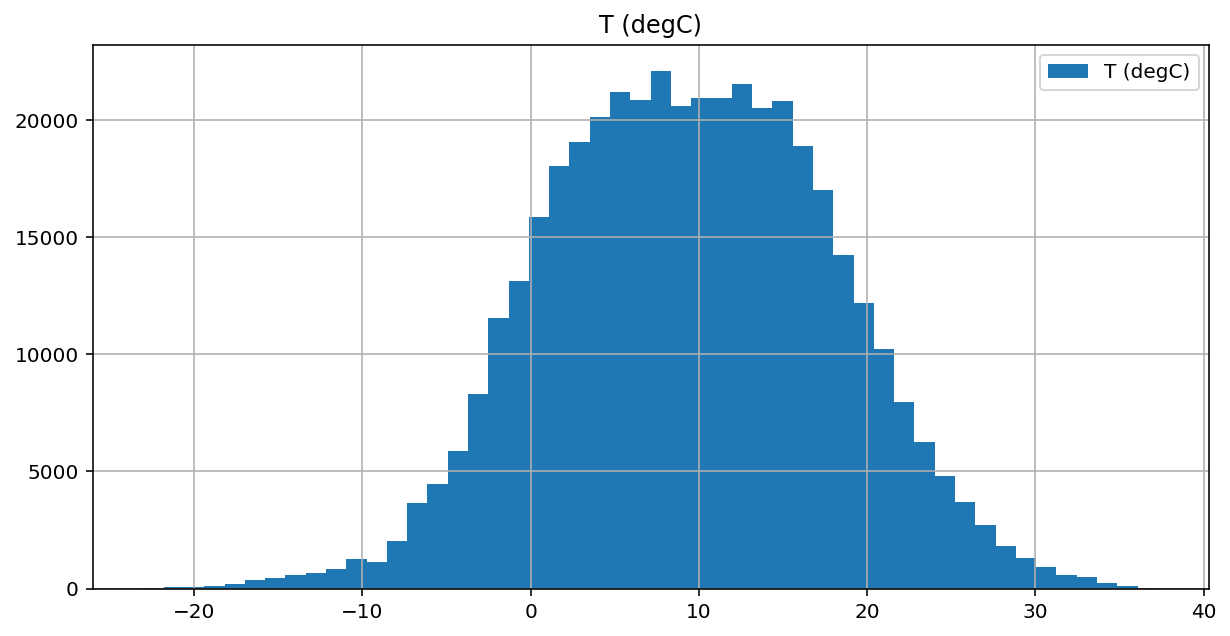

In [47]:
df.hist(column = ['T (degC)'], figsize=(10,5), bins=50, legend=True)

the data distribution is normal. I think we can accept that the data is stationary (taking the ADF test, mean/var, and data distribution into account).

# ARIMA

I choose the ARIMA model which combines three methods including autoregressive, moving average, and integration.

### Searching for order of ARIMA model

ARIMA model is composed of three parts including autoregressive, moving average, and integrated.
auto regressive means the model considers the relationship between an obervation and some lagged observations (history). The integrated part use difference (subtraction) method to make data stationary. Moving average part, first applies a moving average on lagged observationas, second it calculates the difference between the moving average model and the residuals and, finally uses a relationship between an obervation and residuals (predicted by moving average model).

The ARIMA model has three hyper-parameters (p,d,q) which are repersentative for number of lagged observation to be used in autoregressive (so called laged order)(p), the number of times the observations are differenced (d), and the size of moving average window (q).

If the order of p,q are 5, that means the model used last 5 observation to predict the future time-stamps.


ARMA model is used for stationary data, while if the data is not stationary, the ARIMA comes to play.

In [20]:
# !/Users/amin/Desktop/proj/env/bin/python -m pip install pmdarima

In [21]:
from pmdarima import auto_arima

In [20]:
arima_model_fit = auto_arima(training_df, trace=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-8954.351, Time=17.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-115.681, Time=1.45 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-7437.394, Time=0.72 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6594.377, Time=2.76 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-117.195, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-8948.137, Time=13.98 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-7646.579, Time=7.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-8718.054, Time=19.67 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-8966.617, Time=23.57 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-8636.975, Time=11.60 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-9000.620, Time=27.01 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-9007.136, Time=27.72 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-8993.678, Time=25.63 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=-9011.187, Time=33.44 sec
 ARIMA(5,1,2

It is seen that the best ARIMA model has (2,1,3) orders. The summary is provided at the following.

In [21]:
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                20000
Model:               SARIMAX(2, 1, 3)   Log Likelihood                4700.237
Date:                Fri, 15 Oct 2021   AIC                          -9388.473
Time:                        18:29:36   BIC                          -9341.053
Sample:                             0   HQIC                         -9372.959
                              - 20000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9857      0.001   1538.592      0.000       1.983       1.988
ar.L2         -0.9876      0.001   -767.118      0.000      -0.990      -0.985
ma.L1         -1.4953      0.003   -442.849      0.000      -1.502      -1.489
ma.L2          0.1089      0.006     18.814      0.000       0.098       0.120
ma.L3          0.3896      0.004    106.288      0.000       0.382       0.397
sigma2         0.0362      0.000    264.846      0.000       0.036       0.036
===================================================================================
Ljung-Box (L1) (Q):                   4.03   Jarque-Bera (JB):            139023.62
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               1.73   Skew:                            -0.50
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The ARIMA model coeficinet are:

```ar.L1 = 1.9857, ar.L2 = -0.9876, 
ma.L1 = -1.4953, ma.L2 = 0.1089, ma.L3 = 0.3896```


## Prediction

### ARIMA prediction for 72 timestamps ahead

In [23]:
# from statsmodels.tsa.arima.model import ARIMA

In [48]:
# # fit model
# model = ARIMA(df['T (degC)'][0:20000], order=(720,1,0))
# model_fit = model.fit()
# # summary of fit model
# print(model_fit.summary())

In [49]:
# start = len(training_df)
# ahead = 72 # 12 hours ahead
# end = start + ahead


# expected = df['T (degC)'][start:end]
# predicted = arima_model_fit.predict(n_periods=ahead)

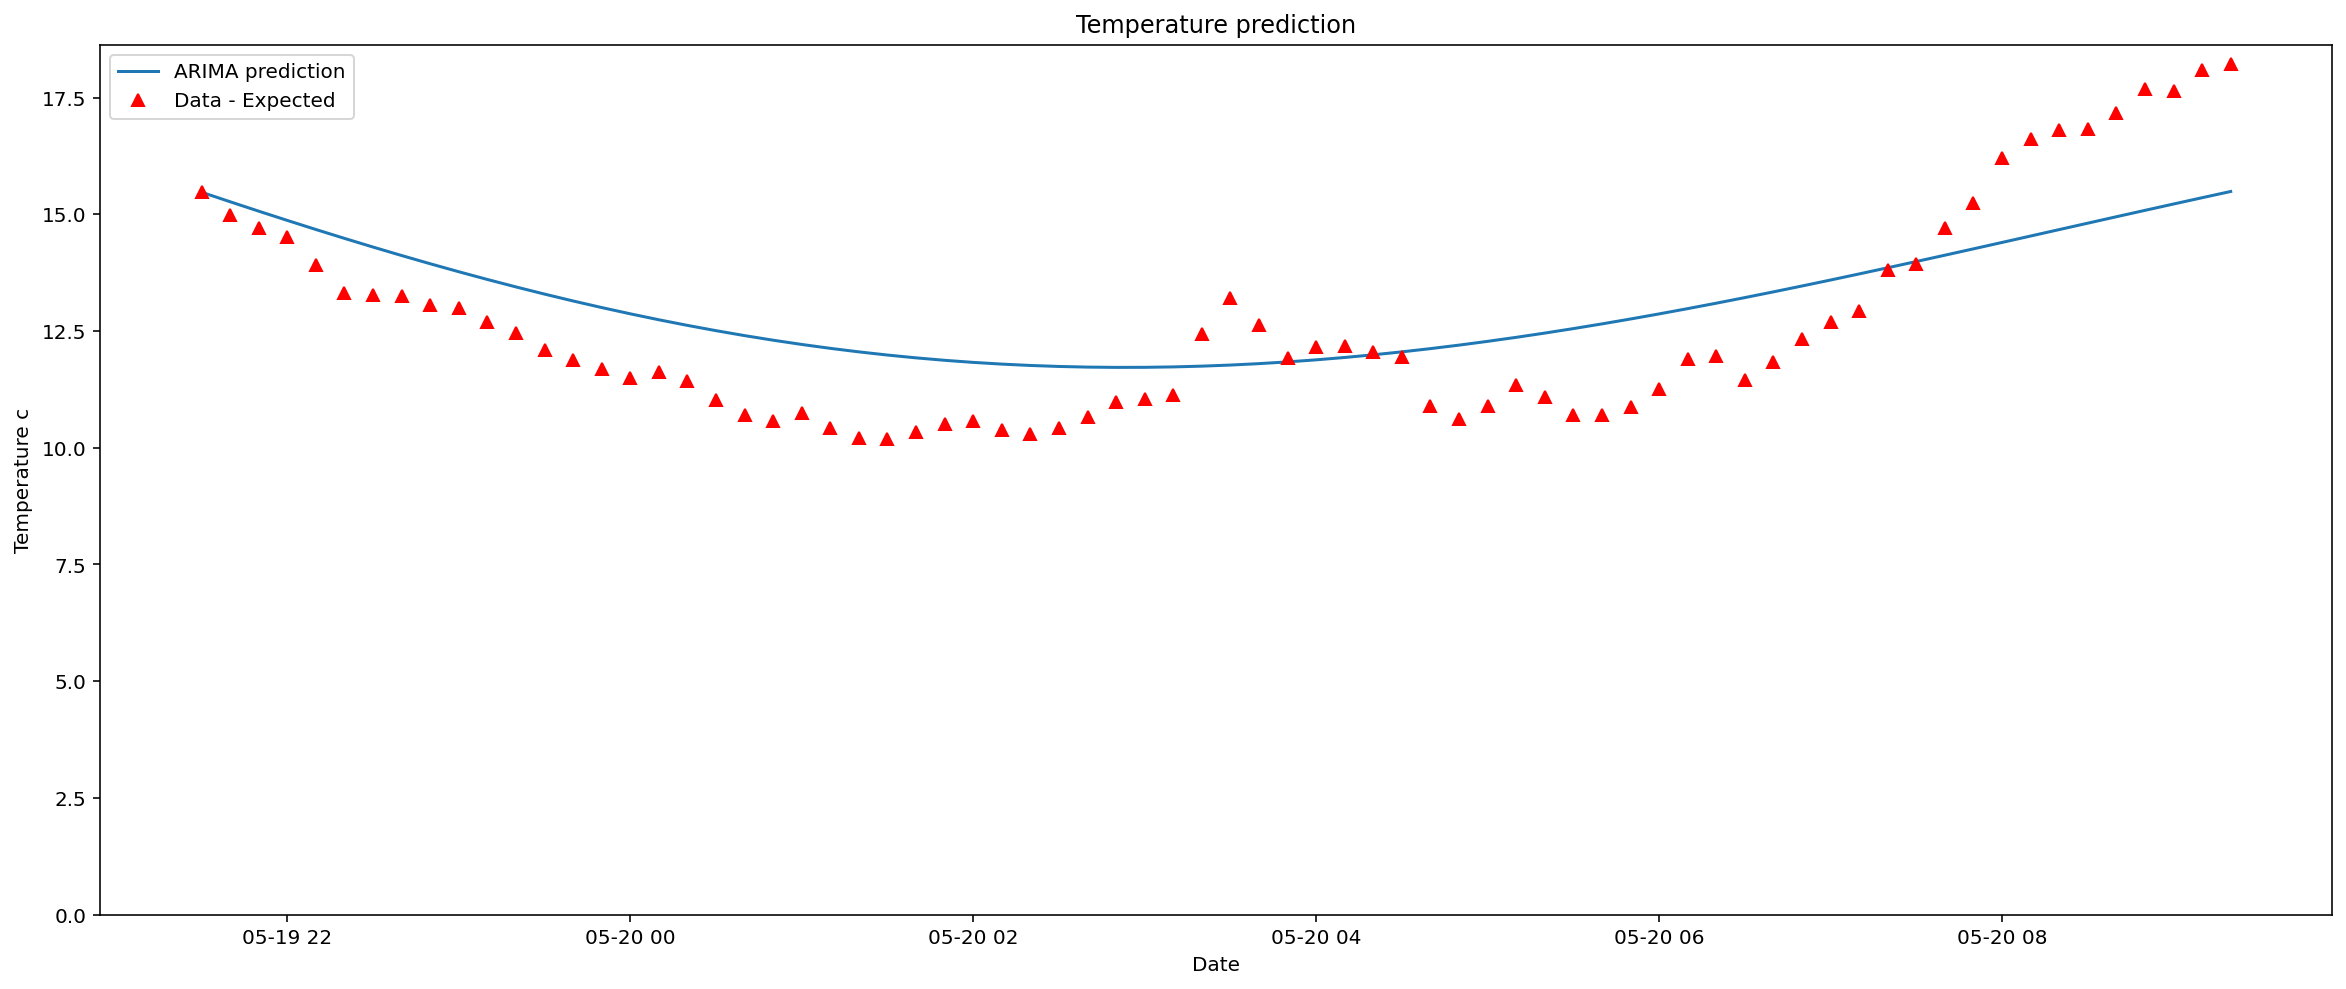

In [22]:
start = len(training_df)
ahead = 72 # 12 hours ahead
end = start + ahead


expected = df['T (degC)'][start:end]
predicted = arima_model_fit.predict(n_periods=ahead)

diff = predicted - expected

predicted = pd.DataFrame(predicted)
predicted.index = df[column_name][start:end].index
diff = pd.DataFrame(diff)


plt.figure(figsize=(20,8))
plt.plot(predicted, label='ARIMA prediction')
plt.plot(expected, 'r^', label='Data - Expected')


plt.xlabel('Date')
plt.ylabel('Temperature c')
plt.title("Temperature prediction")

plt.ylim(0,)

plt.legend()
plt.savefig("../Figures/" + section_fig_main_title + "ARIMA_Temp_esti_72ahead_1.png")

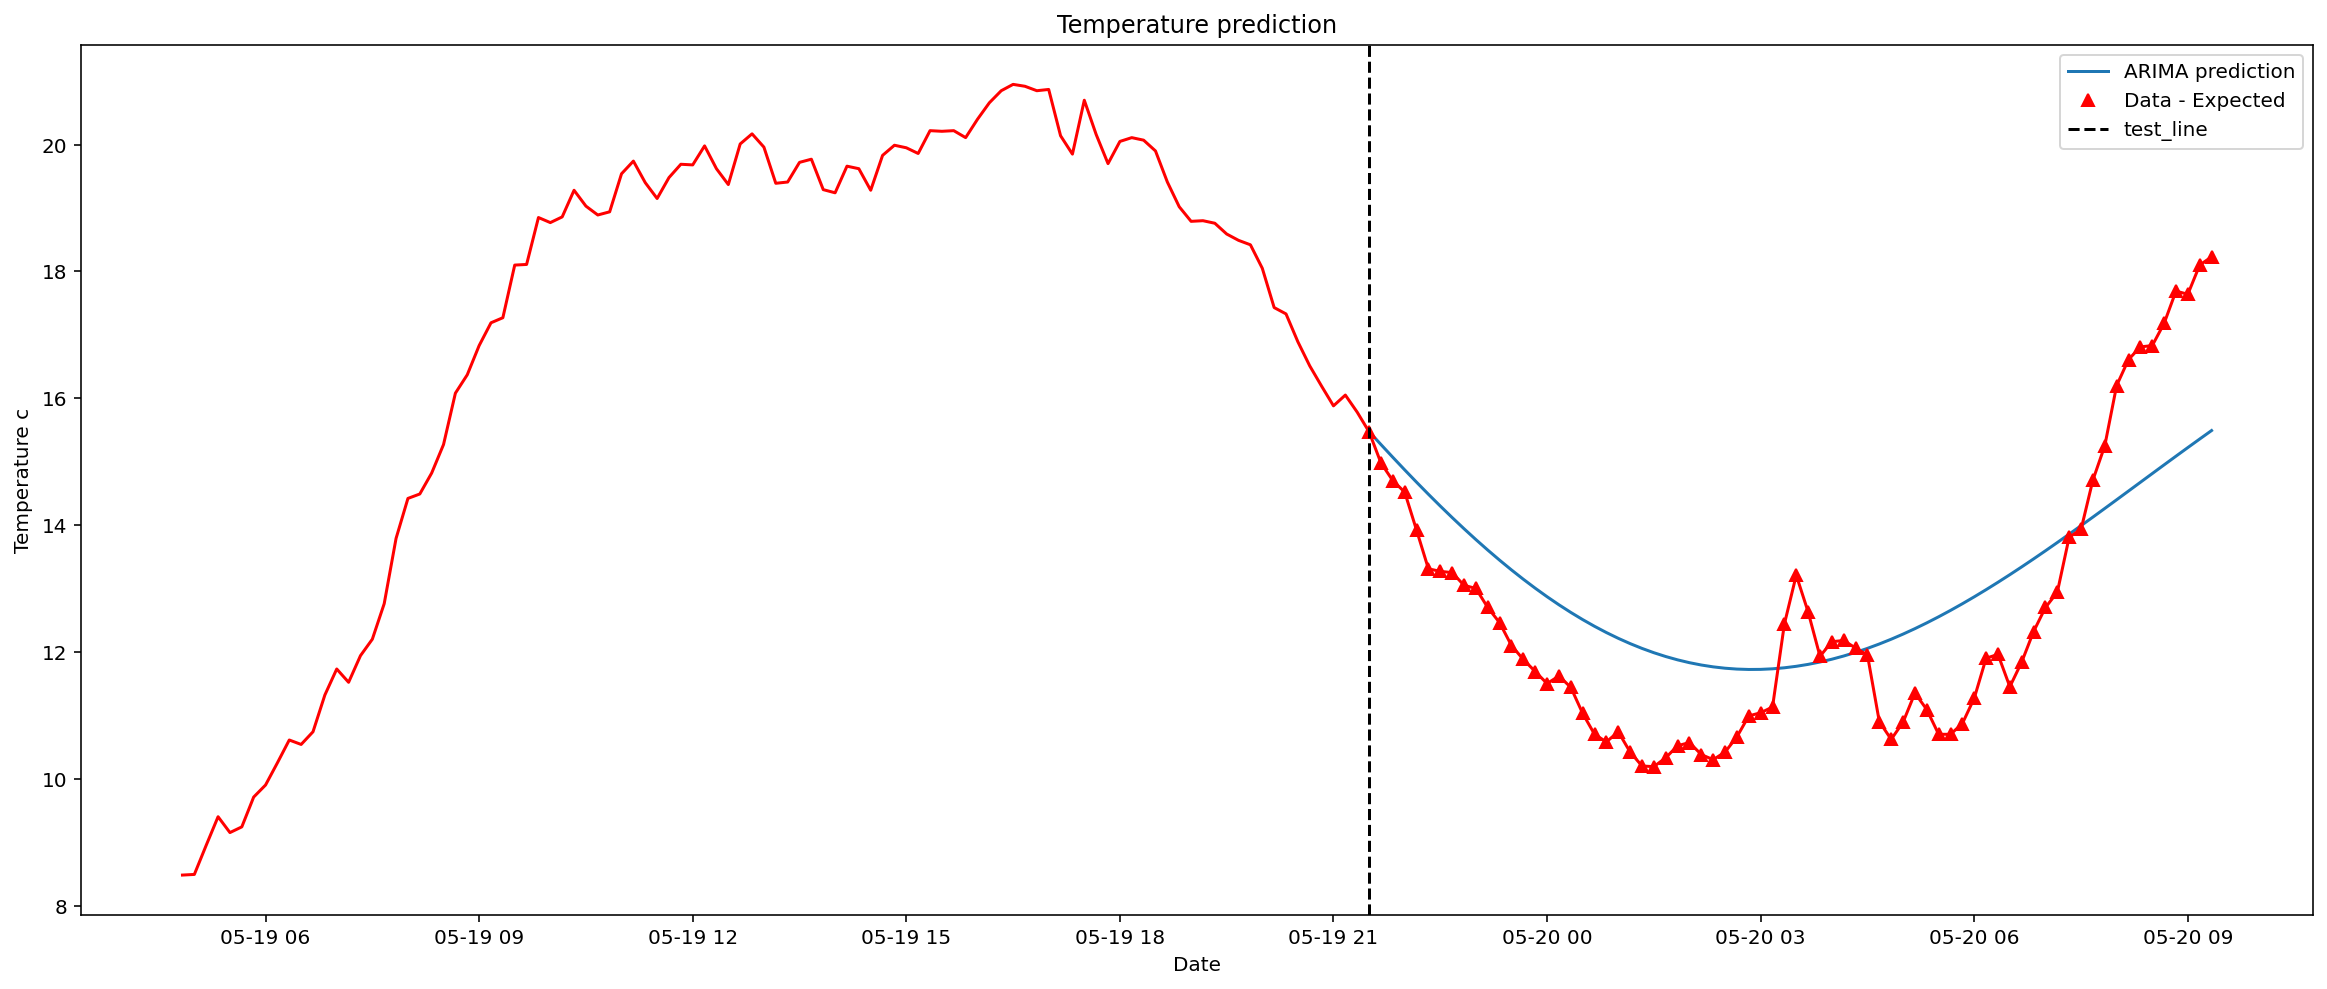

In [137]:
start = len(training_df)
ahead = 72
end = start + ahead

past = 100


expected = df['T (degC)'][start:end]
predicted = arima_model_fit.predict(n_periods=ahead)

diff = predicted - expected

predicted = pd.DataFrame(predicted)
predicted.index = df[column_name][start:end].index
diff = pd.DataFrame(diff)


plt.figure(figsize=(20,8))
plt.plot(predicted, label='ARIMA prediction')
plt.plot(expected, 'r^', label='Data - Expected')



plt.plot(df[column_name][start-past:end], c='r')


plt.xlabel('Date')
plt.ylabel('Temperature c')
plt.title("Temperature prediction")


star = df['T (degC)'][start:start+1].index
plt.axvline(star,color='k', linestyle='--', label='test_line')
# plt.ylim(0,)

plt.legend()

# plt.show()

plt.savefig("../Figures/" + section_fig_main_title + "ARIMA_Temp_esti_72ahead.png")

### ARIMA prediction for 720 timestamps ahead

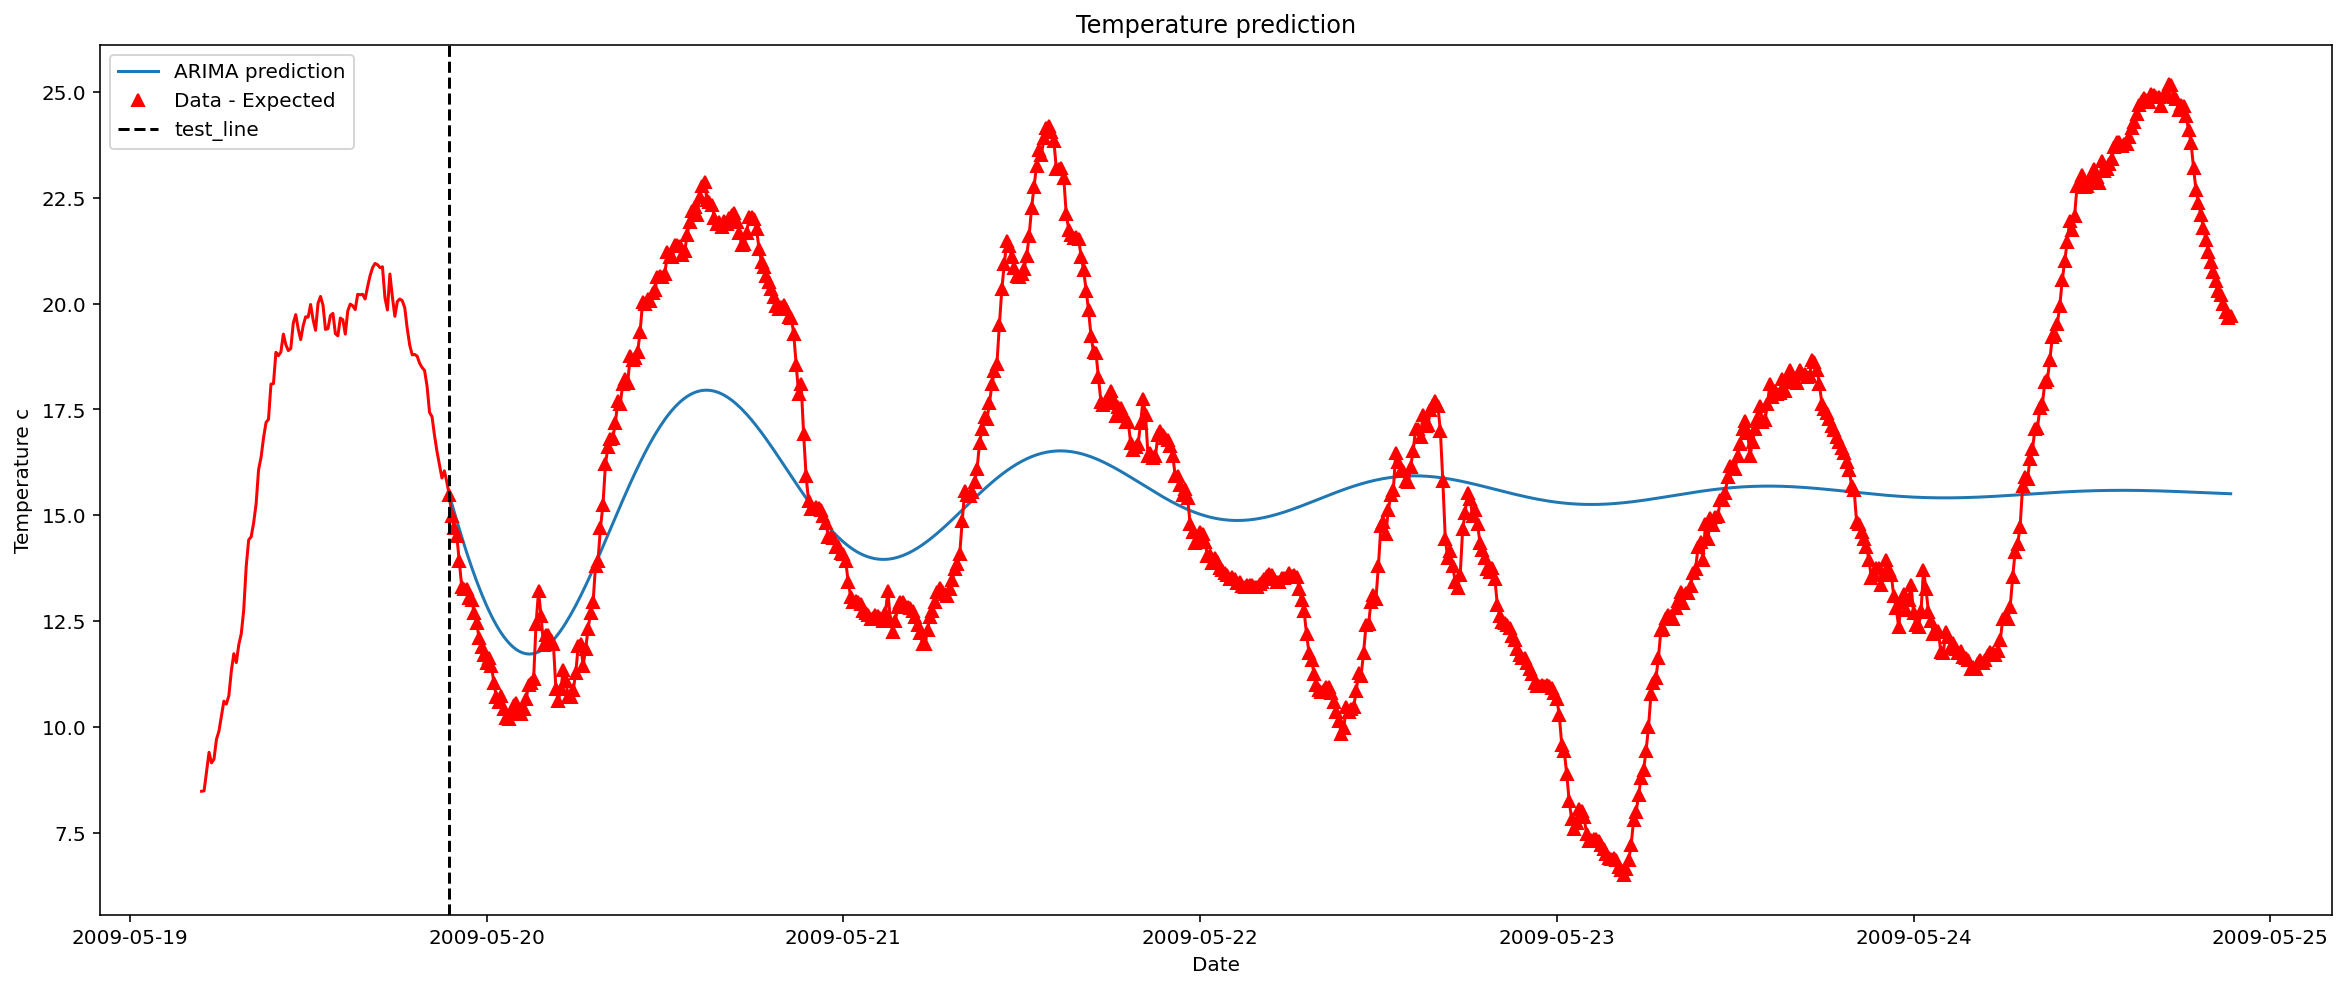

In [138]:
start = len(training_df)
ahead = 720
end = start + ahead

past = 100


expected = df['T (degC)'][start:end]
predicted = arima_model_fit.predict(n_periods=ahead)

diff = predicted - expected

predicted = pd.DataFrame(predicted)
predicted.index = df[column_name][start:end].index
diff = pd.DataFrame(diff)


plt.figure(figsize=(20,8))
plt.plot(predicted, label='ARIMA prediction')
plt.plot(expected, 'r^', label='Data - Expected')



plt.plot(df[column_name][start-past:end], c='r')


plt.xlabel('Date')
plt.ylabel('Temperature c')
plt.title("Temperature prediction")


# star = df['T (degC)'][start].index
star = df['T (degC)'][start:start+1].index
plt.axvline(star,color='k', linestyle='--', label='test_line')

# plt.ylim(0,)

plt.legend()
plt.savefig("../Figures/" + section_fig_main_title + "ARIMA_Temp_esti_720ahead.png")

In [25]:
star = df['T (degC)'][start:start+1].index
star

DatetimeIndex(['2009-05-19 21:30:00'], dtype='datetime64[ns]', name='Date Time', freq=None)

as it is seen from above plot, the model error increases by time. 

The ARIMA model successfully estimates the temperature for future 72 time steamps. 
Applying the ARIMA model for higher time steamps decreases the model estimation accuracy. 

### GIF visualization ARIMA model

let's write a function for plot and use it make an animation visualization.

In [ ]:
@gif.frame
def plott(ahead, past):
    
    start = len(training_df)
    ahead = ahead
    end = start + ahead

    past = past


    expected = df['T (degC)'][start:end]
    predicted = arima_model_fit.predict(n_periods=ahead)

    diff = predicted - expected

    predicted = pd.DataFrame(predicted)
    predicted.index = df[column_name][start:end].index
    diff = pd.DataFrame(diff)


    plt.figure(figsize=(20,8))
    plt.plot(predicted, label='ARIMA prediction')
    plt.plot(expected, 'r^', label='Data - Expected')


    plt.plot(df[column_name][start-past:end], c='r')

    plt.xlabel('Date')
    plt.ylabel('Temperature c')
    plt.title("Temperature prediction")


    star = df['T (degC)'][start:start+1].index
    plt.axvline(star,color='k', linestyle='--', label='test_line')
    # plt.ylim(0,)

    plt.legend()

    # plt.show()

#     plt.savefig("../Figures/" + section_fig_main_title + "Temp_esti_72ahead.png")

In [ ]:
# !/Users/amin/Desktop/proj/env/bin/python -m pip install gif

In [ ]:
# import gif

In [ ]:
frames = []    
for i in range(1,720):

    
    frame = plott(ahead = i, past=100)
    frames.append(frame)
    
# gif.save(frames, "../Figures/GIF.gif", duration=2)

In [ ]:
gif.save(frames, "../Figures/GIF.gif", duration=2)

## Autoregressive (AR)

I apply AR and see how close I can get compare to ARIMA. similarly, i use 20000 sub-data with lags=720 for training and later I apply the model for 72 timestamps ahead (12 hours).

In [76]:
# train autoregression
model = AutoReg(training_df, lags=720)
ar_model_fit = model.fit()
# print('Coefficients: %s' % ar_model_fit.params)

/Users/amin/Desktop/proj/env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/amin/Desktop/proj/env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:599: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)


### AR prediction for 72 timestamps ahead

In [77]:
start = len(training_df)
ahead = 72
end = start + ahead
print('start, ahead, end\n', start, ahead, end)
test = df['T (degC)'][start:end]

start, ahead, end
 20000 72 20072


In [78]:
# make predictions
predictions = ar_model_fit.predict(start=len(training_df), 
                                end=len(training_df)+len(test)-1, 
                                dynamic=False)

# apply same index for prediction df
predictions.index = test.index

/Users/amin/Desktop/proj/env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:393: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


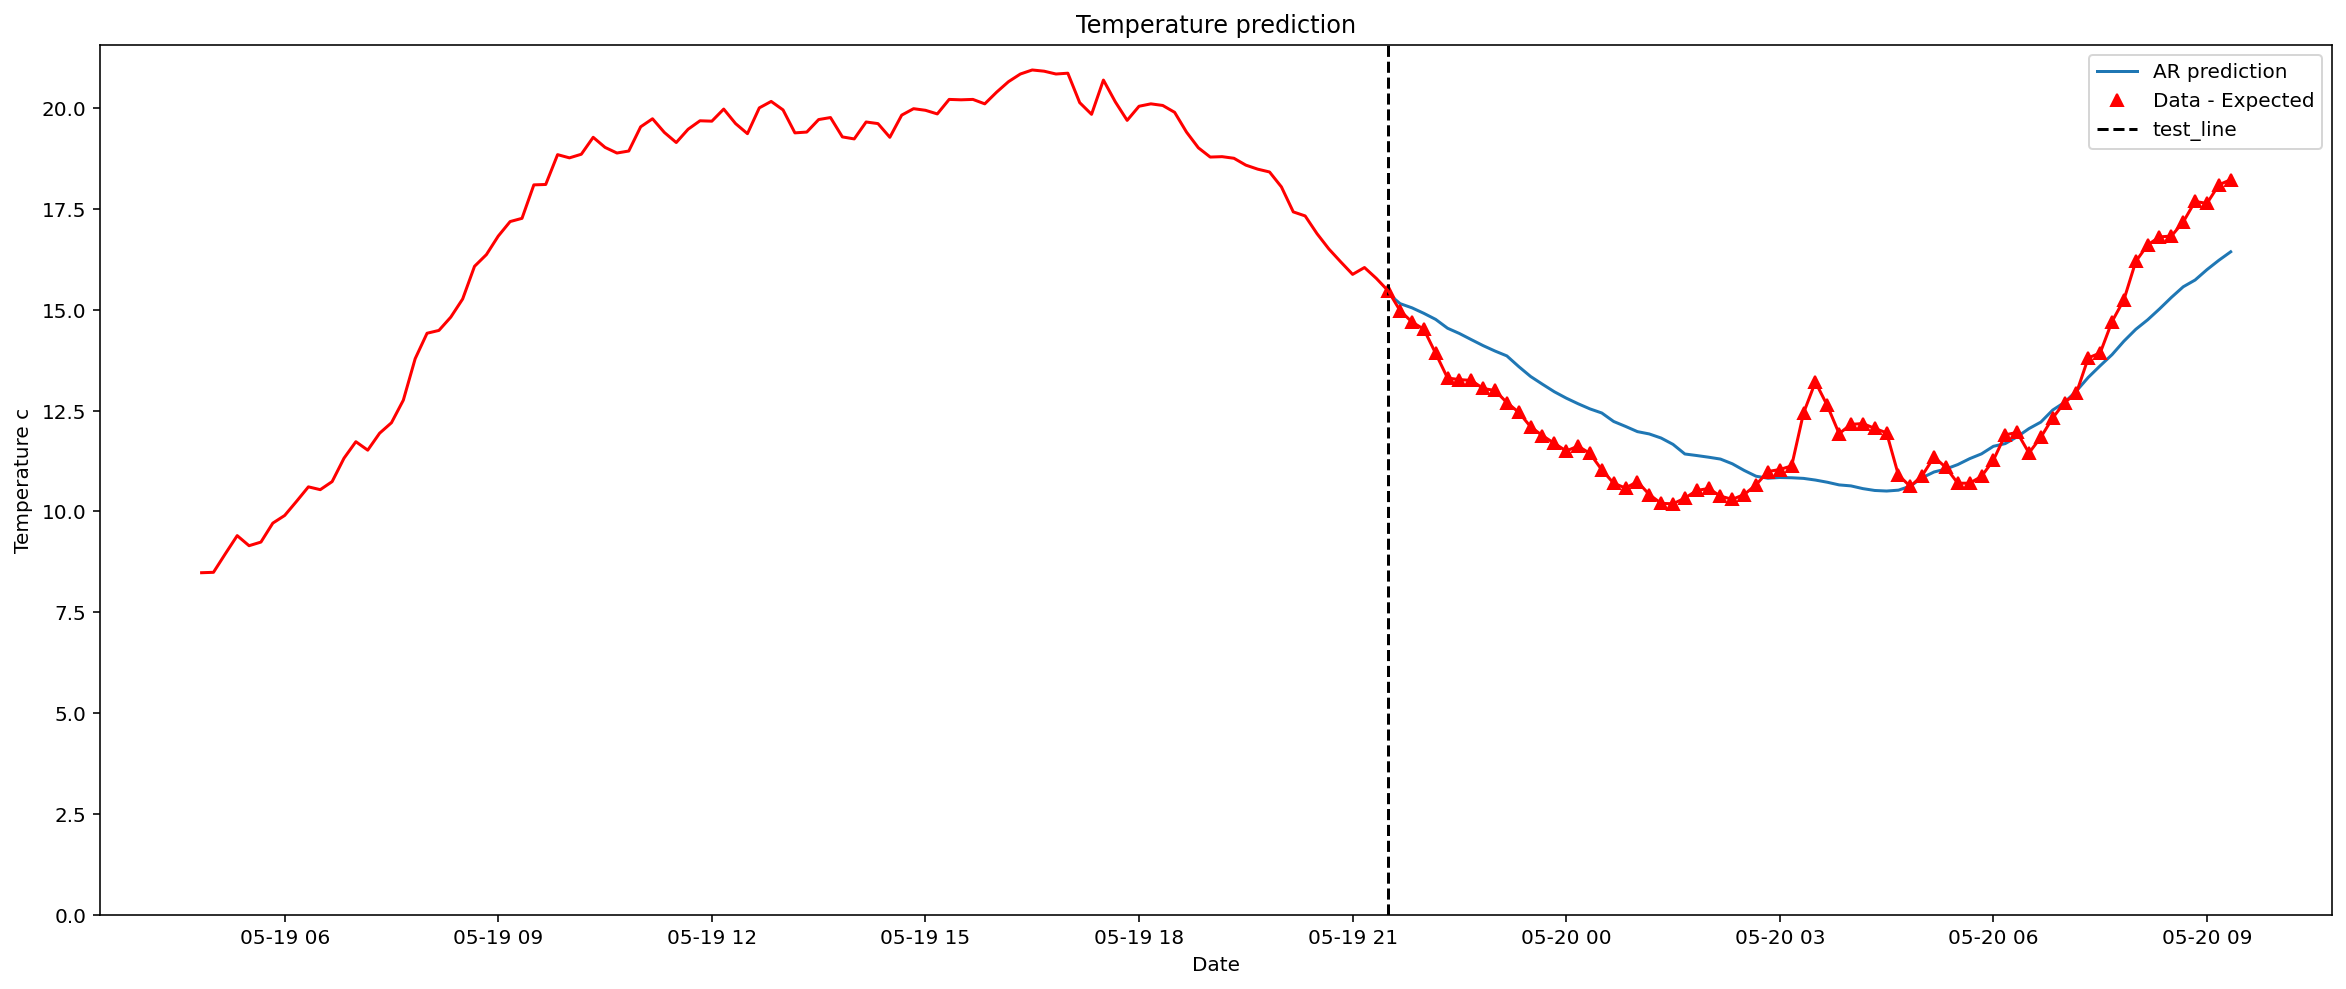

In [79]:
plt.figure(figsize=(20,8))
plt.plot(predictions, label='AR prediction')
plt.plot(test, 'r^', label='Data - Expected')

past = 100

plt.xlabel('Date')
plt.ylabel('Temperature c')
plt.title("Temperature prediction")

star = df['T (degC)'][start:start+1].index
plt.axvline(star,color='k', linestyle='--', label='test_line')
plt.plot(df[column_name][start-past:end], c='r')

plt.ylim(0,)

plt.legend()
plt.savefig("../Figures/" + section_fig_main_title + "AR_Temp_esti_72ahead_1.png")

### AR prediction for 720 timestamps ahead

In [80]:
start = len(training_df)
ahead = 720
end = start + ahead
print('start, ahead, end\n', start, ahead, end)
test = df['T (degC)'][start:end]

start, ahead, end
 20000 720 20720


In [81]:
# make predictions
predictions = ar_model_fit.predict(start=len(training_df), 
                                end=len(training_df)+len(test)-1, 
                                dynamic=False)

# apply same index for prediction df
predictions.index = test.index

/Users/amin/Desktop/proj/env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:393: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


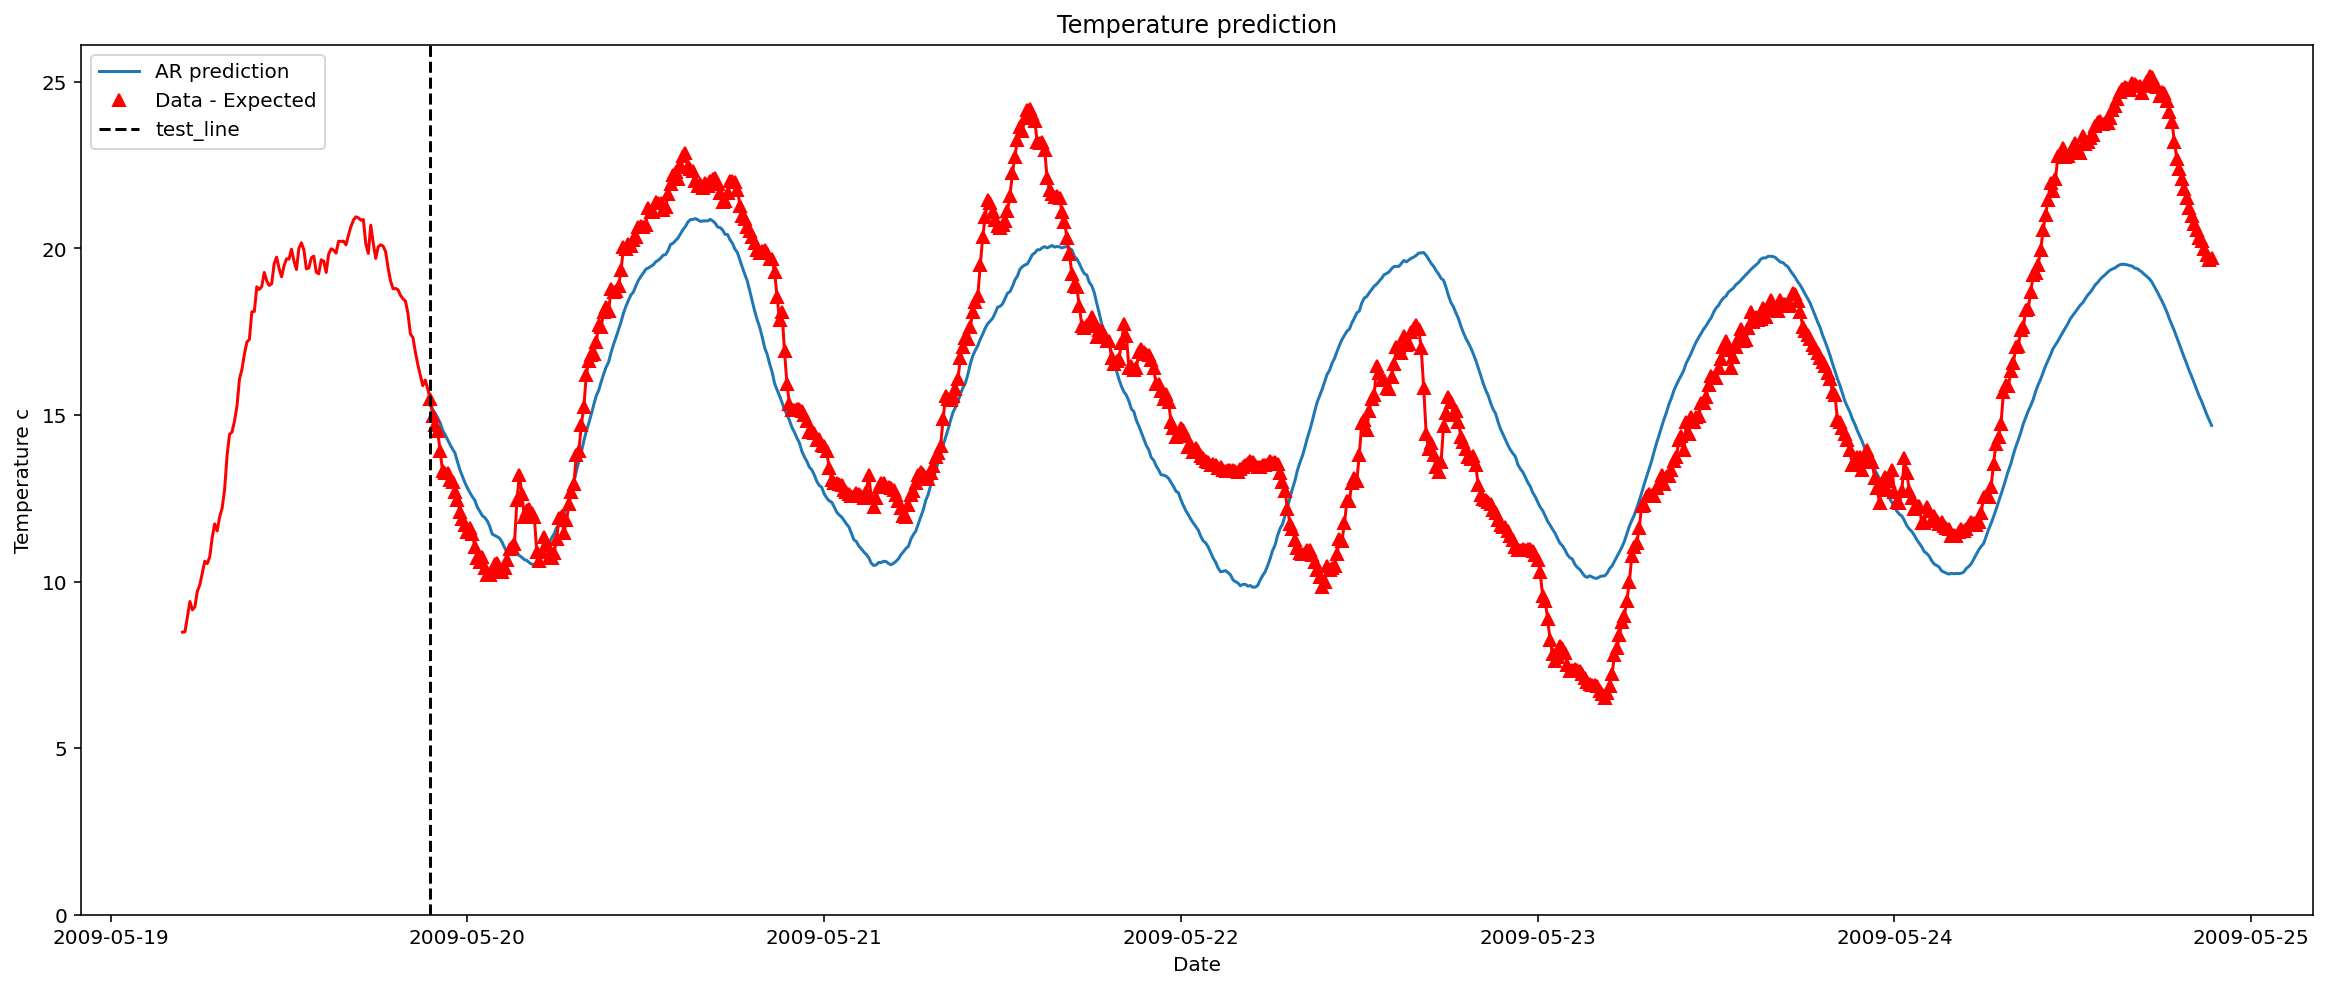

In [82]:
plt.figure(figsize=(20,8))
plt.plot(predictions, label='AR prediction')
plt.plot(test, 'r^', label='Data - Expected')


plt.xlabel('Date')
plt.ylabel('Temperature c')
plt.title("Temperature prediction")


plt.plot(df[column_name][start-past:end], c='r')
star = df['T (degC)'][start:start+1].index
plt.axvline(star,color='k', linestyle='--', label='test_line')
plt.ylim(0,)




plt.legend()
plt.savefig("../Figures/" + section_fig_main_title + "AR_Temp_esti_720ahead_1.png")

In [129]:
@gif.frame
def plott(ahead, past):
    
    start = len(training_df)
    ahead = ahead
    end = start + ahead

    past = past


    expected = df['T (degC)'][start:end]
#     predicted = arima_model_fit.predict(n_periods=ahead)
    predicted =  ar_model_fit.predict(start=len(training_df), 
                                end=end-1, 
                                dynamic=False)

    diff = predicted - expected

    predicted = pd.DataFrame(predicted)
    predicted.index = df[column_name][start:end].index
    diff = pd.DataFrame(diff)


    plt.figure(figsize=(20,8))
    plt.plot(predicted, label='AR prediction')
    plt.plot(expected, 'r^', label='Data - Expected')


    plt.plot(df[column_name][start-past:end], c='r')

    plt.xlabel('Date')
    plt.ylabel('Temperature c')
    plt.title("Temperature prediction")


    star = df['T (degC)'][start:start+1].index
    plt.axvline(star,color='k', linestyle='--', label='test_line')

    plt.legend()

In [83]:
# plott(2, 100)

In [133]:
frames = []    
for i in range(1,720):

    
    frame = plott(ahead = i, past=100)
    frames.append(frame)

In [134]:
gif.save(frames, "../Figures/AR_GIF.gif", duration=2)

Note that the ARIMA model uses 2 lags (d=2) for modeling while in the AR model I applied 72 and 720 lags which results in better estimation. The ARIMA model applied d=1 to make sure data is stationary (suggested by the autoarima library). The data as was observed in the P03_01 and previous EDA part is almost stationary therefore there is no need for applying differencing method.